In [42]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize
from numpy.linalg import cholesky
from scipy.stats import norm

from HJM import*
from useful_functions import*

### import des données

On importe la courbe forward initiale.

In [43]:
df_forward_hours=pd.read_csv('df_forward_hours.csv')
df_forward_hours['Trade Date'] = pd.to_datetime(df_forward_hours['Trade Date'])

## I. Calibration du modèle

##### I.1.a Calcul du crochet empirique

La dynamique du modèle :
$$dF(t, T) = F(t, T)(e^{-\lambda(T - t)}\sigma_{1} dW_{1}(t) + \sigma_{2} dW_{2}(t)) \quad 0 \leq t < T$$
$$dX_{i}(t) = e^{-\lambda_k(T_i - t)}\sigma_{1} dW_{1}(t) + \sigma_{2} dW_{2}(t)$$

avec : 
$$X_{i}(t) := \log F(t, T_i)$$



Le crochet empirique est : 
$$<X_i>_{t}^{t_0} := \lim_{n \to \infty} \sum_{l=1}^{n} (X_{i}(t_{l+1}) - X_{i}(t_{l}))^2$$
$$<X_i, X_j>(t, t_0) := \lim_{n \to \infty} \sum_{l=1}^{n} (X_{i}(t_{l+1}) - X_{i}(t_{l}))(X_{j}(t_{l+1}) - X_{j}(t_{l})) 
$$

In [44]:
def Get_bracket_value(df_forward_hours, T1, T2):

    
    datetime_format = "%d/%m/%Y %H:%M"
    Maturity_1 = datetime.strptime(T1, datetime_format)
    Maturity_2 = datetime.strptime(T2, datetime_format)
    
    Maturity_t0_year = Maturity_1.year - 1
    Maturity_t0_month = max(Maturity_1.month, Maturity_2.month)


    T1_day_of_week = Maturity_1.weekday()  # Corrected this line
    T1_hour = Maturity_1.hour
    T1_hour_column = str(T1_day_of_week) + ' '
    if T1_hour // 10 != 0:
        T1_hour_str = str(T1_hour) + ':00'
    else:
        T1_hour_str = '0' + str(T1_hour) + ':00'
    T1_hour_column = T1_hour_column + T1_hour_str

    T2_day_of_week = Maturity_2.weekday()  # Corrected this line
    T2_hour = Maturity_2.hour
    T2_hour_column = str(T2_day_of_week) + ' '
    if T2_hour // 10 != 0:
        T2_hour_str = str(T2_hour) + ':00'
    else:
        T2_hour_str = '0' + str(T2_hour) + ':00'
    T2_hour_column = T2_hour_column + T2_hour_str

    year = Maturity_t0_year
    month = Maturity_t0_month
    Quotes_T1 = pd.DataFrame()
    Quotes_T2 = pd.DataFrame()
    
    while True:
        
        if year == Maturity_1.year and month == min(Maturity_1.month, Maturity_2.month):
            break

        if year == Maturity_1.year:
            MAH_1 = Maturity_1.month - month
        else:
            MAH_1 = Maturity_1.month + 12 - month

        if year == Maturity_2.year:
            MAH_2 = Maturity_2.month - month
        else:
            MAH_2 = Maturity_2.month + 12 - month


        T1_hour_column_MAH = f'{MAH_1}MAH ' + T1_hour_column
        T2_hour_column_MAH = f'{MAH_2}MAH ' + T2_hour_column
        
        quotes_t1 = df_forward_hours.loc[
            (df_forward_hours['Trade Date'].dt.year == year) &
            (df_forward_hours['Trade Date'].dt.month == month), T1_hour_column_MAH]
        Quotes_T1 = pd.concat([Quotes_T1, quotes_t1], ignore_index=True)
        

        quotes_t2 = df_forward_hours.loc[
            (df_forward_hours['Trade Date'].dt.year == year) &
            (df_forward_hours['Trade Date'].dt.month == month), T2_hour_column_MAH]
        Quotes_T2 = pd.concat([Quotes_T2, quotes_t2], ignore_index=True)
        
        if month + 1 > 12:
            year += 1

        month = (month + 1) % 12
        if month == 0 :
            month = 12
            
    
    Quotes_T1_log=np.log(Quotes_T1)
    Quotes_T1_diff = Quotes_T1_log.diff()
    Quotes_T1_diff.dropna(inplace=True)

    Quotes_T2_log=np.log(Quotes_T2)
    Quotes_T2_diff = Quotes_T2_log.diff()
    Quotes_T2_diff.dropna(inplace=True)
    
    
    return np.sum(Quotes_T1_diff * Quotes_T2_diff).values[0]


In [45]:
def Get_impirical_bracket_dataframe(df_forward_hours,dates):

    n = len(dates)
    df_impirical_bracket = pd.DataFrame(index=dates, columns=dates)
    Impirical_brackets = np.zeros((n, n))

    for i in range(n):
        for j in range(i, n):
            Ti = dates[i]
            Tj = dates[j]

            Impirical_bracket = Get_bracket_value(df_forward_hours,Ti,Tj)
            Impirical_brackets[i, j] = Impirical_bracket
            Impirical_brackets[j, i] = Impirical_bracket

    # Remplir le DataFrame avec les valeurs de covariation

    df_impirical_bracket.iloc[:, :] = Impirical_brackets

    return df_impirical_bracket          

In [46]:
dates=generate_dates(n_dates=100, start='2021-01-01', end='2021-12-31')

In [47]:
df_impirical_bracket=Get_impirical_bracket_dataframe(df_forward_hours,dates)

c:\Users\Utilisateur\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\Utilisateur\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\Utilisateur\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axi

In [48]:
df_impirical_bracket

,04/01/2021 23:00,06/01/2021 21:00,07/01/2021 21:00,11/01/2021 09:00,12/01/2021 18:00,20/01/2021 13:00,20/01/2021 14:00,01/02/2021 11:00,03/02/2021 14:00,15/02/2021 19:00,...,30/11/2021 19:00,01/12/2021 00:00,01/12/2021 18:00,06/12/2021 03:00,07/12/2021 09:00,22/12/2021 02:00,23/12/2021 16:00,24/12/2021 09:00,27/12/2021 07:00,29/12/2021 14:00
04/01/2021 23:00,0.13111,0.13111,0.13111,0.13111,0.13111,0.13111,0.13111,0.108091,0.108091,0.108091,...,0.009106,0.005365,0.005365,0.005365,0.005365,0.005365,0.005365,0.005365,0.005365,0.005365
06/01/2021 21:00,0.13111,0.13111,0.13111,0.13111,0.13111,0.13111,0.13111,0.108091,0.108091,0.108091,...,0.009106,0.005365,0.005365,0.005365,0.005365,0.005365,0.005365,0.005365,0.005365,0.005365
07/01/2021 21:00,0.13111,0.13111,0.13111,0.13111,0.13111,0.13111,0.13111,0.108091,0.108091,0.108091,...,0.009106,0.005365,0.005365,0.005365,0.005365,0.005365,0.005365,0.005365,0.005365,0.005365
11/01/2021 09:00,0.13111,0.13111,0.13111,0.13111,0.13111,0.13111,0.13111,0.108091,0.108091,0.108091,...,0.009106,0.005365,0.005365,0.005365,0.005365,0.005365,0.005365,0.005365,0.005365,0.005365
12/01/2021 18:00,0.13111,0.13111,0.13111,0.13111,0.13111,0.13111,0.13111,0.108091,0.108091,0.108091,...,0.009106,0.005365,0.005365,0.005365,0.005365,0.005365,0.005365,0.005365,0.005365,0.005365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22/12/2021 02:00,0.005365,0.005365,0.005365,0.005365,0.005365,0.005365,0.005365,0.01877,0.01877,0.01877,...,0.249863,0.315416,0.315416,0.315416,0.315416,0.315416,0.315416,0.315416,0.315416,0.315416
23/12/2021 16:00,0.005365,0.005365,0.005365,0.005365,0.005365,0.005365,0.005365,0.01877,0.01877,0.01877,...,0.249863,0.315416,0.315416,0.315416,0.315416,0.315416,0.315416,0.315416,0.315416,0.315416
24/12/2021 09:00,0.005365,0.005365,0.005365,0.005365,0.005365,0.005365,0.005365,0.01877,0.01877,0.01877,...,0.249863,0.315416,0.315416,0.315416,0.315416,0.315416,0.315416,0.315416,0.315416,0.315416
27/12/2021 07:00,0.005365,0.005365,0.005365,0.005365,0.005365,0.005365,0.005365,0.01877,0.01877,0.01877,...,0.249863,0.315416,0.315416,0.315416,0.315416,0.315416,0.315416,0.315416,0.315416,0.315416


##### I.1.b Calcul du crochet théorique

crochet théorique : 
$$<X_i>_{t}^{t_0}=\sigma_{1}^2 \cdot 2\lambda \left( e^{-2\lambda(T_i - t)} - e^{-2\lambda(T_i - t_0)} \right) + \left( \sigma_{2} \right)^2 (t - t_0) + \frac{2\sigma_{1}\sigma_{2}\rho}{\lambda} \left( e^{-\lambda(T_i - t)} - e^{-\lambda(T_i - t_0)} \right)$$
$$<X_i,X_j>_{t}^{t_0} = \sigma_{2}^2 (t - t_0) - \frac{e^{-\lambda(T_i + T_j)}\sigma_{1}^2}{2\lambda} \left( e^{2\lambda t} - e^{2\lambda t_0} \right) + \frac{\sigma_{1}\sigma_{2}\rho \left( e^{-\lambda T_i} + e^{-\lambda T_j} \right) \left( e^{\lambda t} - e^{\lambda t_0} \right)}{\lambda}$$


In [49]:
def Get_First_quotation_time(T):
    '''Fonction qui permet de retrouver la première date de quotation pour laquelle on peut observer la maturité T'''
    if not isinstance(T, pd.Timestamp):
        T = pd.Timestamp(T)
    
    # La première date de quotation pour laquelle on peut observer la maturité T est le premier jour (à minuit) du même mois que T mais un an en avance

    return pd.Timestamp(year=T.year - 1, month=T.month, day=1, hour=0, minute=0, second=0, microsecond=0)

def Get_Last_quotation_time(T):
    '''Fonction qui permet de retrouver la dernière date de quotation pour laquelle on peut observer la maturité T'''
    # Convert the Timestamp to a datetime object if it's not already one
    if not isinstance(T, pd.Timestamp):
        T = pd.Timestamp(T)

    # La dernière date de quotation pour laquelle on peut observer la maturité T est le dernièr jour (à 23:00:00) du mois précédent celui de la date T

    # Cas particulier si T se trouve en janvier
    if T.month == 1:
        return pd.Timestamp(year=T.year - 1, month=12, day=31, hour=23, minute=0, second=0, microsecond=0)
    else:
        # La même date mais un mois en avant
        adjusted_timestamp = T - pd.DateOffset(months=1)
        # Explicitly set the time to midnight
        return pd.Timestamp(year=adjusted_timestamp.year, month=adjusted_timestamp.month, day=calendar.monthrange(adjusted_timestamp.year, adjusted_timestamp.month)[1], hour=23, minute=0, second=0, microsecond=0)
    
def Get_brackets_borns(Ti, Tj):
    '''Fonction qui permet de retrouver la première date et la dernière date de quotation pour lequelles on peut observer simultanément les deux maturité Ti et Tj'''
    First_quotation_Ti = Get_First_quotation_time(Ti)
    First_quotation_Tj = Get_First_quotation_time(Tj)
    Last_quotation_Ti = Get_Last_quotation_time(Ti)
    Last_quotation_Tj = Get_Last_quotation_time(Tj)
    
    # Return the latest of the first instants and the earliest of the last instants
    return max(First_quotation_Ti, First_quotation_Tj), min(Last_quotation_Ti, Last_quotation_Tj)

In [50]:
def quadratic_covariation(t0, t, Ti, Tj, sigma1, sigma2, lambda_param, rho):
    '''Fonction qui permet le calcul du crochet théorique'''
    # convertir la différence de date en unité de temps en année
    t_minus_t0 = year_fraction(t, t0)
    Ti_minus_t0 = year_fraction(Ti, t0)
    Tj_minus_t0 = year_fraction(Tj, t0)
    Ti_minus_t = year_fraction(Ti, t)
    Tj_minus_t = year_fraction(Tj, t)
    
    if Ti!=Tj:
        
        first_term = (sigma2**2) * t_minus_t0
        coeff_1 = (sigma1**2) / (2 * lambda_param)
        second_term = coeff_1 * (np.exp(-lambda_param *(Ti_minus_t0 + Tj_minus_t0)) - np.exp((Ti_minus_t + Tj_minus_t)))
        coeff_2 = (sigma1 * sigma2 * rho) / lambda_param
        third_term = coeff_2 * (np.exp(-lambda_param * Ti_minus_t) - np.exp(-lambda_param * Ti_minus_t0) + np.exp(-lambda_param * Ti_minus_t) - np.exp(-lambda_param * Ti_minus_t0))

    else:

        coeff_1 = (sigma1**2) / (2 * lambda_param)
        first_term=coeff_1*(np.exp(-2*lambda_param * Ti_minus_t) - np.exp(-2*lambda_param * Ti_minus_t0))
        second_term=(sigma2**2) * t_minus_t0
        coeff_2 = 2*(sigma1 * sigma2 * rho) / lambda_param
        third_term=coeff_2*(np.exp(-lambda_param * Ti_minus_t) - np.exp(-lambda_param * Ti_minus_t0))

    return first_term + second_term + third_term

In [51]:
def Get_theoretical_bracket(Ti, Tj, sigma1_squared, sigma2_squared, lambda_param, rho):
    t0, t = Get_brackets_borns(Ti, Tj)
    # Convertir les variances en volatilités (écart-types)
    sigma1 = np.sqrt(sigma1_squared)
    sigma2 = np.sqrt(sigma2_squared)
    return 

In [52]:
def Get_theoretical_bracket_dataframe(dates, sigma1, sigma2, lambda_param, rho):
    n = len(dates)
    df_theoretical_bracket = pd.DataFrame(index=dates, columns=dates)
    covariation_values = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            Ti = dates[i]
            Tj = dates[j]
            t0, t = Get_brackets_borns(Ti, Tj)
            # Assurez-vous que calcul_crochet_exact est correctement défini pour gérer les objets datetime Ti et Tj
            covariation = quadratic_covariation(t0, t, Ti, Tj, sigma1, sigma2, lambda_param, rho)
            covariation_values[i, j] = covariation
            covariation_values[j, i] = covariation
    # Remplir le DataFrame avec les valeurs de covariation
    df_theoretical_bracket.iloc[:, :] = covariation_values
    return df_theoretical_bracket  

##### I.2 Optimization

L'optimisation se fait à travers la minimisation de l'érreur quadratique moyenne entre le crochet théorique et le crochet empirique.

\begin{equation*}
\ \hat{p}=min_{p} \sum_{i,j=1}^{N} \left( \overline{\left\langle X_{i} , X_{j} \right\rangle^{T_{1_{i,j}}}_{T^{0}_{i,j}}} - \left\langle X_{i} , X_{j} \right\rangle^{T_{1_{i,j}}}_{T^{0}_{i,j}} \right)^2
\end{equation*}

où :
$$ P=[\sigma_1,  \sigma_2, \lambda, \rho]


In [53]:
def square_error(df1, df2):
    """
    Prend deux DataFrame en entrée et retourne un DataFrame contenant
    la différence des coefficients, élevée au carré.
    
    Arguments:
    df1, df2 -- DataFrame Pandas contenant les coefficients numériques.
    
    Retourne:
    DataFrame des différences au carré.
    """
    # Assurer que les index et les colonnes des deux DataFrame correspondent
    if not df1.index.equals(df2.index) or not df1.columns.equals(df2.columns):
        raise ValueError("Les index ou les colonnes des DataFrame ne correspondent pas.")
    
    # Calculer la différence et l'élever au carré
    diff_carre = (df1 - df2) ** 2
    
    return diff_carre

In [54]:
def fonction_objectif(params, dates, df_empirical_bracket):
    sigma1, sigma2, lambda_param, rho = params
    # Générer le DataFrame théorique avec les paramètres actuels
    df_theoretical_bracket = Get_theoretical_bracket_dataframe(dates, sigma1, sigma2, lambda_param, rho)
    # Calculer la différence au carré entre le DataFrame empirique et théorique
    Err= square_error(df_empirical_bracket, df_theoretical_bracket)
    # Somme des différences au carré pour utiliser comme objectif d'optimisation
    Mean_square_error = np.mean(Err.values)
    return Mean_square_error

def optimisation(dates, df_empirical_bracket):
    # Bornes pour les paramètres : (min, max)
    bornes = [(1.5, 3), (0.7, 1.5), (80,120), (-1, 1)]
    # Valeurs initiales pour l'optimisation
    x0 = [0.03, 0.04, 0.5, 0.5]
    # Lancer l'optimisation
    Opt_params = minimize(fonction_objectif, x0, args=(dates, df_empirical_bracket), bounds=bornes)
    return Opt_params.x  # Renvoie les paramètres optimisés

In [55]:
Opt_params=optimisation(dates, df_impirical_bracket)

In [56]:
print(Opt_params)

[ 3.   0.7 80.  -1. ]


In [57]:
sigma1 = Opt_params[0]
sigma2 = Opt_params[1]
lambda_param = Opt_params[2]
rho = Opt_params[3]

df_theoretical_bracket = Get_theoretical_bracket_dataframe(dates, sigma1, sigma2, lambda_param, rho)

In [58]:
df_theoretical_bracket

,04/01/2021 23:00,06/01/2021 21:00,07/01/2021 21:00,11/01/2021 09:00,12/01/2021 18:00,20/01/2021 13:00,20/01/2021 14:00,01/02/2021 11:00,03/02/2021 14:00,15/02/2021 19:00,...,30/11/2021 19:00,01/12/2021 00:00,01/12/2021 18:00,06/12/2021 03:00,07/12/2021 09:00,22/12/2021 02:00,23/12/2021 16:00,24/12/2021 09:00,27/12/2021 07:00,29/12/2021 14:00
04/01/2021 23:00,0.484064,0.299055,0.253056,0.058997,0.009915,0.291958,0.29195,0.295639,0.386602,0.341689,...,0.050478,0.29372,0.293567,0.297151,0.250938,0.003596,0.003089,0.002862,0.00192,0.001175
06/01/2021 21:00,0.299055,0.484637,0.34535,0.15575,0.108025,0.19646,0.196449,0.200809,0.293556,0.247257,...,0.148544,0.198541,0.19836,0.388857,0.343559,0.10268,0.102251,0.102059,0.101262,0.100632
07/01/2021 21:00,0.253056,0.34535,0.484637,0.202798,0.155661,0.148587,0.148576,0.153309,0.247039,0.199993,...,0.196161,0.150847,0.15065,0.386486,0.388817,0.150738,0.150343,0.150166,0.149432,0.148852
11/01/2021 09:00,0.058997,0.15575,0.202798,0.488886,0.340481,-0.055047,-0.055062,-0.048441,0.050361,-0.000456,...,0.380916,-0.051886,-0.05216,0.196249,0.243434,0.336971,0.336689,0.336563,0.33604,0.335626
12/01/2021 18:00,0.009915,0.108025,0.155661,0.340481,0.485564,-0.10707,-0.107087,-0.099891,0.000482,-0.051483,...,0.383195,-0.103634,-0.103933,0.148312,0.196097,0.386076,0.385816,0.3857,0.385218,0.384836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22/12/2021 02:00,0.003596,0.10268,0.150738,0.336971,0.386076,-0.116295,-0.116306,-0.145735,-0.043177,-0.061231,...,0.379376,-0.116609,-0.116217,0.138273,0.186731,0.489437,0.426005,0.425881,0.425371,0.424968
23/12/2021 16:00,0.003089,0.102251,0.150343,0.336689,0.385816,-0.116978,-0.116989,-0.146385,-0.04373,-0.06185,...,0.379071,-0.117275,-0.116886,0.137832,0.186324,0.426005,0.489585,0.425755,0.425243,0.424838
24/12/2021 09:00,0.002862,0.102059,0.150166,0.336563,0.3857,-0.117284,-0.117296,-0.146676,-0.043978,-0.062127,...,0.378934,-0.117575,-0.117185,0.137634,0.186142,0.425881,0.425755,0.489636,0.42517,0.424764
27/12/2021 07:00,0.00192,0.101262,0.149432,0.33604,0.385218,-0.118552,-0.118563,-0.147883,-0.045005,-0.063277,...,0.378367,-0.118813,-0.118426,0.136815,0.185387,0.425371,0.425243,0.42517,0.489781,0.42439


In [59]:
df_impirical_bracket

,04/01/2021 23:00,06/01/2021 21:00,07/01/2021 21:00,11/01/2021 09:00,12/01/2021 18:00,20/01/2021 13:00,20/01/2021 14:00,01/02/2021 11:00,03/02/2021 14:00,15/02/2021 19:00,...,30/11/2021 19:00,01/12/2021 00:00,01/12/2021 18:00,06/12/2021 03:00,07/12/2021 09:00,22/12/2021 02:00,23/12/2021 16:00,24/12/2021 09:00,27/12/2021 07:00,29/12/2021 14:00
04/01/2021 23:00,0.13111,0.13111,0.13111,0.13111,0.13111,0.13111,0.13111,0.108091,0.108091,0.108091,...,0.009106,0.005365,0.005365,0.005365,0.005365,0.005365,0.005365,0.005365,0.005365,0.005365
06/01/2021 21:00,0.13111,0.13111,0.13111,0.13111,0.13111,0.13111,0.13111,0.108091,0.108091,0.108091,...,0.009106,0.005365,0.005365,0.005365,0.005365,0.005365,0.005365,0.005365,0.005365,0.005365
07/01/2021 21:00,0.13111,0.13111,0.13111,0.13111,0.13111,0.13111,0.13111,0.108091,0.108091,0.108091,...,0.009106,0.005365,0.005365,0.005365,0.005365,0.005365,0.005365,0.005365,0.005365,0.005365
11/01/2021 09:00,0.13111,0.13111,0.13111,0.13111,0.13111,0.13111,0.13111,0.108091,0.108091,0.108091,...,0.009106,0.005365,0.005365,0.005365,0.005365,0.005365,0.005365,0.005365,0.005365,0.005365
12/01/2021 18:00,0.13111,0.13111,0.13111,0.13111,0.13111,0.13111,0.13111,0.108091,0.108091,0.108091,...,0.009106,0.005365,0.005365,0.005365,0.005365,0.005365,0.005365,0.005365,0.005365,0.005365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22/12/2021 02:00,0.005365,0.005365,0.005365,0.005365,0.005365,0.005365,0.005365,0.01877,0.01877,0.01877,...,0.249863,0.315416,0.315416,0.315416,0.315416,0.315416,0.315416,0.315416,0.315416,0.315416
23/12/2021 16:00,0.005365,0.005365,0.005365,0.005365,0.005365,0.005365,0.005365,0.01877,0.01877,0.01877,...,0.249863,0.315416,0.315416,0.315416,0.315416,0.315416,0.315416,0.315416,0.315416,0.315416
24/12/2021 09:00,0.005365,0.005365,0.005365,0.005365,0.005365,0.005365,0.005365,0.01877,0.01877,0.01877,...,0.249863,0.315416,0.315416,0.315416,0.315416,0.315416,0.315416,0.315416,0.315416,0.315416
27/12/2021 07:00,0.005365,0.005365,0.005365,0.005365,0.005365,0.005365,0.005365,0.01877,0.01877,0.01877,...,0.249863,0.315416,0.315416,0.315416,0.315416,0.315416,0.315416,0.315416,0.315416,0.315416


In [60]:
df_impirical_bracket-df_theoretical_bracket

,04/01/2021 23:00,06/01/2021 21:00,07/01/2021 21:00,11/01/2021 09:00,12/01/2021 18:00,20/01/2021 13:00,20/01/2021 14:00,01/02/2021 11:00,03/02/2021 14:00,15/02/2021 19:00,...,30/11/2021 19:00,01/12/2021 00:00,01/12/2021 18:00,06/12/2021 03:00,07/12/2021 09:00,22/12/2021 02:00,23/12/2021 16:00,24/12/2021 09:00,27/12/2021 07:00,29/12/2021 14:00
04/01/2021 23:00,-0.352954,-0.167945,-0.121946,0.072113,0.121195,-0.160848,-0.16084,-0.187549,-0.278512,-0.233598,...,-0.041372,-0.288355,-0.288202,-0.291786,-0.245573,0.001769,0.002276,0.002504,0.003445,0.00419
06/01/2021 21:00,-0.167945,-0.353527,-0.21424,-0.02464,0.023085,-0.06535,-0.065339,-0.092719,-0.185466,-0.139166,...,-0.139438,-0.193176,-0.192995,-0.383491,-0.338193,-0.097315,-0.096886,-0.096694,-0.095897,-0.095267
07/01/2021 21:00,-0.121946,-0.21424,-0.353527,-0.071688,-0.024551,-0.017477,-0.017466,-0.045219,-0.138949,-0.091903,...,-0.187054,-0.145481,-0.145285,-0.381121,-0.383452,-0.145373,-0.144978,-0.1448,-0.144067,-0.143486
11/01/2021 09:00,0.072113,-0.02464,-0.071688,-0.357776,-0.209371,0.186157,0.186172,0.156532,0.05773,0.108547,...,-0.37181,0.057251,0.057526,-0.190883,-0.238069,-0.331606,-0.331324,-0.331198,-0.330675,-0.330261
12/01/2021 18:00,0.121195,0.023085,-0.024551,-0.209371,-0.354454,0.23818,0.238197,0.207982,0.107608,0.159574,...,-0.374089,0.109,0.109298,-0.142947,-0.190732,-0.380711,-0.380451,-0.380335,-0.379852,-0.379471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22/12/2021 02:00,0.001769,-0.097315,-0.145373,-0.331606,-0.380711,0.12166,0.121672,0.164505,0.061947,0.080001,...,-0.129513,0.432025,0.431633,0.177143,0.128686,-0.174021,-0.110588,-0.110465,-0.109955,-0.109552
23/12/2021 16:00,0.002276,-0.096886,-0.144978,-0.331324,-0.380451,0.122343,0.122354,0.165155,0.0625,0.08062,...,-0.129208,0.432692,0.432302,0.177584,0.129092,-0.110588,-0.174169,-0.110339,-0.109827,-0.109422
24/12/2021 09:00,0.002504,-0.096694,-0.1448,-0.331198,-0.380335,0.122649,0.122661,0.165446,0.062748,0.080897,...,-0.129071,0.432991,0.432602,0.177782,0.129275,-0.110465,-0.110339,-0.17422,-0.109754,-0.109348
27/12/2021 07:00,0.003445,-0.095897,-0.144067,-0.330675,-0.379852,0.123917,0.123929,0.166653,0.063775,0.082047,...,-0.128504,0.434229,0.433843,0.178601,0.13003,-0.109955,-0.109827,-0.109754,-0.174365,-0.108974


## II. Validation de la méthode : calibration de données simulées

Pour valider la méthode de calibration, on commence par calibrer sur des données simulées:\
l'idée est la suivante : 
- Choisir une date de quotation initiale t0, (ci dessous on prendra t0=02-01-2020 )
- Fixer des paramètres $\sigma_1, \sigma_2, \lambda, \rho$
- A partir de la courbe forward initiale de l'instant t0, effectuer des simulations HJM avec les paramètres cités ci-haut, pour plusieurs date de quotations
- Ces date de quotation permettent d'avoir un historique de prix similaire au cas réel
- effectuer la calibration décrite dans le paragraphe précédent. 

##### II.1 simulation des prix

In [61]:
base_date = str(df_forward_hours.iloc[0]['Trade Date']).split()[0]

converted_df_weekday_hour = convert_columns_to_ordered_datetime(df_forward_hours, base_date)
converted_df_weekday_hour.head()

,2020-02-01 00:00:00,2020-02-01 01:00:00,2020-02-01 02:00:00,2020-02-01 03:00:00,2020-02-01 04:00:00,2020-02-01 05:00:00,2020-02-01 06:00:00,2020-02-01 07:00:00,2020-02-01 08:00:00,2020-02-01 09:00:00,...,2021-01-31 14:00:00,2021-01-31 15:00:00,2021-01-31 16:00:00,2021-01-31 17:00:00,2021-01-31 18:00:00,2021-01-31 19:00:00,2021-01-31 20:00:00,2021-01-31 21:00:00,2021-01-31 22:00:00,2021-01-31 23:00:00
2020-01-02,46.846796,45.859624,45.641607,46.247081,44.780988,42.451141,39.300209,35.791075,36.344957,38.426216,...,38.417085,38.358037,39.058373,42.56089,45.376703,47.88132,48.549182,48.294954,49.136308,48.640636


In [62]:
def simulate_forward_prices_for_maturities(maturities, t0,FT_t0, vecteur_ai, rho_matrix, sigmas, N,HJM_sim='Barette'):

    '''Fonction qui permet de réaliser plusieurs projections HJM sur plusieurs dates de quotations à partir d'une courbe foraward initiale donnée,
    HJM_sim : paramètre qui fixe la méthode de simulation HJM
    '''
    simulation_results = {}

    if not isinstance(t0, pd.Timestamp):
        t0 = pd.Timestamp(t0)
    # Iterate over each maturity
    
    for T in maturities:

        if (T in converted_df_weekday_hour.columns):
            if not isinstance(T, pd.Timestamp):
                T = pd.Timestamp(T)

            # Calculer le nombre de pas de simulation, chaque pas représentant une heure.
            # Nous soustrayons une heure à T pour que le dernier point de simulation soit à T-1.
            num_hours = int((T - t0).total_seconds() / 3600) - 1
            num_steps = num_hours  
    
            # Nous simulons le prix pour l'échéance donnée.
            # Il est à noter que HJM_fixed_maturity/EDS_HJM doit retourner une liste de prix simulés, un pour chaque pas.
            if HJM_sim=='Barette':
                simulated_prices = HJM_fixed_maturity(N, vecteur_ai, rho_matrix, sigmas, num_steps, FT_t0[T].values[0], T, t0, T - pd.Timedelta(hours=1))
            elif HJM_sim=='EDS':
                simulated_prices= EDS_HJM(FT_t0[T].values[0],t0,T - pd.Timedelta(hours=1),T,num_steps,vecteur_ai,sigmas,rho_matrix[0,1])
            
            # Stocker les prix simulés dans le dictionnaire de résultats
            simulation_results[T] = simulated_prices
        
    # Maintenant, nous créons un DataFrame à partir du dictionnaire.
    # Nous utilisons NaN pour les valeurs manquantes, car différentes échéances ont différents nombres de pas de simulation.

    simulation_df = pd.DataFrame.from_dict(simulation_results, orient='index')

    # Transposer le DataFrame pour avoir les échéances en lignes et les prix simulés en colonnes.
    simulation_df = simulation_df.transpose()

    # Nommage des colonnes séquentiellement comme 'valeur 0', 'valeur 1', ..., 'valeur N-1'
    simulation_df.columns = [f'{i}' for i in simulation_df.columns]

    return simulation_df.T

In [63]:
# Simulation d'un historique de prix grâce à HJM

N = 2  # Nombre de facteurs
vecteur_ai = [80,0]  # Le paramètre lambda
rho_matrix = np.array([[1, 0.7], [0.7, 1]])  # La matrice de corrélation des browniens
sigmas = [0.6,1.3]  # Les paramètres sigma1 et sigma2

mi=int(2*len(converted_df_weekday_hour.columns)/3) # on ne considère que des maturités assez éloignées de l'instant de quotation afin d'avoir plusieur dates d'observation
start_date=str(converted_df_weekday_hour.columns[mi]).split()[0]
end_date=str(converted_df_weekday_hour.columns[-1]).split()[0]

# Nous choisissons un certain nombre de valeurs parmis ces maturités
maturities=generate_dates(n_dates=30, start=start_date, end=end_date)

# Test de la fonction
df=simulate_forward_prices_for_maturities(maturities, base_date,converted_df_weekday_hour, vecteur_ai, rho_matrix, sigmas, N,HJM_sim='EDS')

##### II.2.a Calcul du crochet empirique

In [64]:
def calculate_sum(df, date_i, date_j):
    '''Crochet empirique'''
    i = df.index.get_loc(date_i)
    j = df.index.get_loc(date_j)
    total_sum = 0
    for l in range(len(df.columns) - 1):
        Xi_l = df.iloc[i, l]
        Xj_l = df.iloc[j, l]
        Xi_next = df.iloc[i, l + 1]
        Xj_next = df.iloc[j, l + 1]
        if pd.isnull(Xi_l) or pd.isnull(Xj_l) or pd.isnull(Xi_next) or pd.isnull(Xj_next):
            break
        total_sum += (Xi_next - Xi_l) * (Xj_next - Xj_l)
    return total_sum

def create_cross_table(df):
    '''Creation du dataframe des crochets empiriques'''
    cross_table = pd.DataFrame(index=df.index, columns=df.index)
    for i in cross_table.index:
        for j in cross_table.columns:
            if i <= j:
                cross_table.loc[i, j] = calculate_sum(df, i, j)
                cross_table.loc[j, i] = cross_table.loc[i, j]
            else:
                continue
    return cross_table

In [65]:
df_empirical_bracket = create_cross_table(np.log(df))

##### I.2.b Calcul du crochet théorique

In [66]:
def last_common_quote_index(df, date1, date2):
    '''indice de la dernière date de quotation commune entre les deux maturité date1 et date2'''

    if date1 not in df.index or date2 not in df.index:
        raise ValueError("One or both dates are not in the DataFrame index.")
    X1=df.loc[date1].dropna()
    X2=df.loc[date2].dropna()
    last_index = min(X1.shape[0],X2.shape[0])
    
    return last_index

def get_date_from_index(t0, index):
    if not isinstance(t0, pd.Timestamp):
        t0 = pd.Timestamp(t0)
    result_date = t0 + pd.Timedelta(hours=index)
    return result_date

def Get_theoretical_bornes_2(df, Ti, Tj, t0):
    '''Fonction qui permet de trouver la dernière date de quotation commune entre les deux maturité date1 et date2'''
    index = last_common_quote_index(df, Ti, Tj)
    date = get_date_from_index(t0, index)
    return date

def Get_brackets_borns_2(df, t0,Ti, Tj):
    '''Fonction qui permet de trouver la première et la dernière date de quotation communes entre les deux maturité date1 et date2'''
    First_quotation = t0
    Last_quotation = Get_theoretical_bornes_2(df, Ti, Tj, t0)
    return First_quotation, Last_quotation 

def Get_theoretical_bracket_dataframe_2(dates, t0, sigma1, sigma2, lambda_param, rho):
    
    n = len(dates)
    df_theoretical_bracket = pd.DataFrame(index=dates, columns=dates)
    covariation_values = np.zeros((n, n))

    for i in range(n):
        for j in range(i, n):
            
            Ti = dates[i]
            Tj = dates[j]
            t0, t = Get_brackets_borns_2(df, t0,Ti, Tj)
            covariation = quadratic_covariation(t0, t, Ti, Tj, sigma1, sigma2, lambda_param, rho)
            covariation_values[i, j] = covariation
            covariation_values[j, i] = covariation

    df_theoretical_bracket.iloc[:, :] = covariation_values
    return df_theoretical_bracket

In [67]:
maturities=df.index.tolist()

In [68]:
sigma1 = sigmas[0]
sigma2 = sigmas[1]
lambda_param = vecteur_ai[0]
rho = rho_matrix[0,1]
df_theoretical_bracket = Get_theoretical_bracket_dataframe_2(maturities, base_date, sigma1, sigma2, lambda_param, rho)

In [69]:
df_theoretical_bracket

,2020-02-10 21:00:00,2020-05-10 23:00:00,2020-06-10 03:00:00,2020-10-15 20:00:00,2020-10-21 11:00:00,2020-10-23 11:00:00,2020-10-23 20:00:00,2020-10-26 21:00:00,2020-10-29 06:00:00,2020-02-11 05:00:00,...,2020-11-30 07:00:00,2020-03-12 08:00:00,2020-09-12 01:00:00,2020-11-12 03:00:00,2020-12-14 17:00:00,2020-12-21 16:00:00,2020-12-23 13:00:00,2020-12-30 00:00:00,2021-01-20 15:00:00,2021-01-28 18:00:00
2020-02-10 21:00:00,0.199663,0.194575,0.194328,0.193023,0.192954,0.19293,0.192925,0.192887,0.192857,0.195201,...,0.192437,0.195008,0.193414,0.19268,0.192235,0.192135,0.192108,0.192013,0.191667,0.191536
2020-05-10 23:00:00,0.194575,0.615624,0.610971,0.60995,0.609897,0.609877,0.609874,0.609844,0.609821,0.182593,...,0.609492,0.321922,0.610256,0.609682,0.609335,0.609256,0.609235,0.609161,0.608893,0.608791
2020-06-10 03:00:00,0.194328,0.610971,0.754918,0.749519,0.749469,0.749451,0.749448,0.749421,0.7494,0.182346,...,0.749097,0.321695,0.7498,0.749272,0.748952,0.74888,0.74886,0.748791,0.748546,0.748452
2020-10-15 20:00:00,0.193023,0.60995,0.749519,1.34461,1.340115,1.340102,1.3401,1.340081,1.340066,0.181042,...,1.339852,0.320494,1.170382,1.339976,1.33975,1.339699,1.339685,1.339637,1.339466,1.3394
2020-10-21 11:00:00,0.192954,0.609897,0.749469,1.340115,1.370583,1.366111,1.366109,1.36609,1.366075,0.180973,...,1.365864,0.32043,1.170338,1.365986,1.365764,1.365714,1.3657,1.365652,1.365485,1.36542
2020-10-23 11:00:00,0.19293,0.609877,0.749451,1.340102,1.366111,1.379818,1.375356,1.375337,1.375322,0.180949,...,1.375113,0.320408,1.170323,1.375234,1.375013,1.374963,1.374949,1.374902,1.374735,1.374671
2020-10-23 20:00:00,0.192925,0.609874,0.749448,1.3401,1.366109,1.375356,1.38155,1.377071,1.377056,0.180944,...,1.376847,0.320403,1.17032,1.376968,1.376747,1.376697,1.376684,1.376636,1.37647,1.376405
2020-10-26 21:00:00,0.192887,0.609844,0.749421,1.340081,1.36609,1.375337,1.377071,1.395594,1.39112,0.180906,...,1.390913,0.320369,1.170298,1.391032,1.390813,1.390764,1.390751,1.390704,1.390539,1.390475
2020-10-29 06:00:00,0.192857,0.609821,0.7494,1.340066,1.366075,1.375322,1.377056,1.39112,1.406561,0.180877,...,1.401895,0.320341,1.170282,1.402014,1.401797,1.401747,1.401734,1.401687,1.401524,1.40146
2020-02-11 05:00:00,0.195201,0.182593,0.182346,0.181042,0.180973,0.180949,0.180944,0.180906,0.180877,0.201203,...,0.193981,0.19655,0.194957,0.194223,0.193779,0.193679,0.193652,0.193557,0.193211,0.193081


In [70]:
df_empirical_bracket

,2020-02-10 21:00:00,2020-05-10 23:00:00,2020-06-10 03:00:00,2020-10-15 20:00:00,2020-10-21 11:00:00,2020-10-23 11:00:00,2020-10-23 20:00:00,2020-10-26 21:00:00,2020-10-29 06:00:00,2020-02-11 05:00:00,...,2020-11-30 07:00:00,2020-03-12 08:00:00,2020-09-12 01:00:00,2020-11-12 03:00:00,2020-12-14 17:00:00,2020-12-21 16:00:00,2020-12-23 13:00:00,2020-12-30 00:00:00,2021-01-20 15:00:00,2021-01-28 18:00:00
2020-02-10 21:00:00,0.180612,-0.002142,-0.008211,-0.002697,0.003549,0.000697,-0.000105,0.003499,0.005928,0.002953,...,0.002926,0.004701,-0.003197,0.005599,-0.004607,0.012422,0.000643,0.012195,0.005733,-0.004059
2020-05-10 23:00:00,-0.002142,0.593616,0.000435,-0.010461,-0.016648,0.006066,0.012026,0.013669,0.008541,0.007681,...,-0.017159,0.00211,0.006759,0.005705,0.000224,-0.009833,0.020105,-0.010666,-0.011661,0.018759
2020-06-10 03:00:00,-0.008211,0.000435,0.747513,-0.003886,0.016747,0.017792,0.000338,0.003863,-0.017363,0.004044,...,-0.001528,0.003036,-0.008653,0.00913,-0.010395,-0.025486,0.013944,-0.003323,0.013984,0.015082
2020-10-15 20:00:00,-0.002697,-0.010461,-0.003886,1.331159,-0.00684,-0.023225,-0.01268,0.021105,-0.006907,0.012755,...,0.027894,-0.006483,-0.029389,0.015661,0.013239,-0.009227,0.00788,-0.011358,-0.025593,-0.003836
2020-10-21 11:00:00,0.003549,-0.016648,0.016747,-0.00684,1.326055,-0.011032,-0.006318,0.019109,-0.000082,-0.000329,...,0.025589,-0.005433,-0.039913,-0.019919,0.006872,0.008581,-0.02085,-0.035914,0.022576,-0.012787
2020-10-23 11:00:00,0.000697,0.006066,0.017792,-0.023225,-0.011032,1.338814,-0.009614,0.004663,-0.000467,0.000579,...,-0.001451,-0.016503,-0.012425,0.002725,0.021043,0.005132,-0.011947,0.007631,0.00722,-0.016143
2020-10-23 20:00:00,-0.000105,0.012026,0.000338,-0.01268,-0.006318,-0.009614,1.376189,-0.025736,-0.007378,-0.001429,...,0.013144,0.008041,-0.010586,0.013369,0.003647,-0.021977,-0.022863,-0.01635,0.018867,-0.001646
2020-10-26 21:00:00,0.003499,0.013669,0.003863,0.021105,0.019109,0.004663,-0.025736,1.421105,-0.010542,-0.000847,...,-0.001979,0.010469,-0.011503,-0.000736,-0.006679,0.010363,0.006825,-0.003775,0.000809,0.007107
2020-10-29 06:00:00,0.005928,0.008541,-0.017363,-0.006907,-0.000082,-0.000467,-0.007378,-0.010542,1.422482,-0.000655,...,0.002059,0.004015,-0.023154,0.024156,0.010084,0.015984,-0.007909,0.00525,-0.014878,-0.003721
2020-02-11 05:00:00,0.002953,0.007681,0.004044,0.012755,-0.000329,0.000579,-0.001429,-0.000847,-0.000655,0.190441,...,-0.00188,-0.000601,0.003951,-0.007889,0.005018,-0.000647,0.000152,0.003629,0.003689,0.007061


In [71]:
df_empirical_bracket-df_theoretical_bracket

,2020-02-10 21:00:00,2020-05-10 23:00:00,2020-06-10 03:00:00,2020-10-15 20:00:00,2020-10-21 11:00:00,2020-10-23 11:00:00,2020-10-23 20:00:00,2020-10-26 21:00:00,2020-10-29 06:00:00,2020-02-11 05:00:00,...,2020-11-30 07:00:00,2020-03-12 08:00:00,2020-09-12 01:00:00,2020-11-12 03:00:00,2020-12-14 17:00:00,2020-12-21 16:00:00,2020-12-23 13:00:00,2020-12-30 00:00:00,2021-01-20 15:00:00,2021-01-28 18:00:00
2020-02-10 21:00:00,-0.019051,-0.196717,-0.202539,-0.19572,-0.189406,-0.192233,-0.19303,-0.189388,-0.18693,-0.192249,...,-0.189511,-0.190307,-0.196611,-0.18708,-0.196842,-0.179713,-0.191465,-0.179818,-0.185934,-0.195595
2020-05-10 23:00:00,-0.196717,-0.022008,-0.610536,-0.620412,-0.626544,-0.603812,-0.597848,-0.596175,-0.60128,-0.174912,...,-0.626651,-0.319812,-0.603497,-0.603977,-0.609111,-0.619089,-0.58913,-0.619827,-0.620554,-0.590032
2020-06-10 03:00:00,-0.202539,-0.610536,-0.007406,-0.753405,-0.732722,-0.731659,-0.749111,-0.745558,-0.766762,-0.178302,...,-0.750625,-0.318659,-0.758453,-0.740142,-0.759347,-0.774365,-0.734916,-0.752114,-0.734562,-0.73337
2020-10-15 20:00:00,-0.19572,-0.620412,-0.753405,-0.01345,-1.346955,-1.363327,-1.35278,-1.318976,-1.346972,-0.168287,...,-1.311958,-0.326977,-1.199771,-1.324315,-1.326511,-1.348926,-1.331805,-1.350994,-1.36506,-1.343236
2020-10-21 11:00:00,-0.189406,-0.626544,-0.732722,-1.346955,-0.044529,-1.377143,-1.372427,-1.346981,-1.366157,-0.181302,...,-1.340276,-0.325863,-1.21025,-1.385905,-1.358892,-1.357133,-1.38655,-1.401566,-1.342909,-1.378207
2020-10-23 11:00:00,-0.192233,-0.603812,-0.731659,-1.363327,-1.377143,-0.041004,-1.38497,-1.370674,-1.375789,-0.180369,...,-1.376564,-0.33691,-1.182748,-1.372509,-1.35397,-1.369831,-1.386896,-1.367271,-1.367516,-1.390814
2020-10-23 20:00:00,-0.19303,-0.597848,-0.749111,-1.35278,-1.372427,-1.38497,-0.00536,-1.402807,-1.384435,-0.182373,...,-1.363704,-0.312362,-1.180906,-1.363599,-1.3731,-1.398674,-1.399547,-1.392986,-1.357603,-1.378051
2020-10-26 21:00:00,-0.189388,-0.596175,-0.745558,-1.318976,-1.346981,-1.370674,-1.402807,0.025511,-1.401662,-0.181753,...,-1.392892,-0.3099,-1.181801,-1.391769,-1.397493,-1.380401,-1.383925,-1.394478,-1.389729,-1.383367
2020-10-29 06:00:00,-0.18693,-0.60128,-0.766762,-1.346972,-1.366157,-1.375789,-1.384435,-1.401662,0.015921,-0.181532,...,-1.399836,-0.316327,-1.193436,-1.377859,-1.391713,-1.385763,-1.409643,-1.396437,-1.416401,-1.405181
2020-02-11 05:00:00,-0.192249,-0.174912,-0.178302,-0.168287,-0.181302,-0.180369,-0.182373,-0.181753,-0.181532,-0.010762,...,-0.195861,-0.197151,-0.191006,-0.202113,-0.188762,-0.194327,-0.1935,-0.189927,-0.189523,-0.18602


On remarque que l'erreur est pluôt faible sur les valeurs en diagonale.

In [72]:
def square_error_2(df1, df2):
    if not df1.index.equals(df2.index) or not df1.columns.equals(df2.columns):
        raise ValueError("Les index ou les colonnes des DataFrame ne correspondent pas.")
    return np.diag((df1 - df2) ** 2)

def fonction_objectif_2(params, maturities, df_empirical_bracket, t0):
    sigma1_squared, sigma2_squared, lambda_param, rho = params
    
    df_theoretical_bracket = Get_theoretical_bracket_dataframe_2(maturities, t0, sigma1_squared, sigma2_squared, lambda_param, rho)
    Err = square_error_2(df_empirical_bracket, df_theoretical_bracket)
    Mean_square_error = np.mean(Err)
    return Mean_square_error

def optimisation_2(maturities, df_empirical_bracket, t0):
    bornes = [(0, 1), (0.8, 2), (50,200), (-1, 1)]
    x0 = [0.1, 1, 60, 0.5]
   
    Opt_params = minimize(fonction_objectif_2, x0, args=(maturities, df_empirical_bracket, t0), bounds=bornes)
    return Opt_params.x

In [73]:

Opt_params = optimisation_2(maturities, df_empirical_bracket, base_date)

In [74]:
Opt_params

array([ 0.10560479,  1.30013698, 59.99999096,  0.50102718])

L'estimateur se rapproche bien de $\sigma_2$ et de $\lambda$ mais n'arrive pas à bien estimer $\sigma_1$ et $\rho$

Inspectons la convergence des crochets empiriques vers les crochets théoriques:

Cas Ti=Tj :

In [95]:
Ti='2020-10-15 20:00:00'
Tj='2020-10-15 20:00:00'
t0=base_date
maturities=[Ti]
simulation_results={}

In [101]:
def test_convergence(maturities,steps_precision,t0,FT_t0, vecteur_ai, rho_matrix, sigmas):

    if not isinstance(t0, pd.Timestamp):
        t0 = pd.Timestamp(t0)

    for T in maturities:

        if (T in converted_df_weekday_hour.columns):
            if not isinstance(T, pd.Timestamp):
                T = pd.Timestamp(T)

            # Calculer le nombre de pas de simulation, chaque pas représentant une heure.
            # Nous soustrayons une heure à T pour que le dernier point de simulation soit à T-1.
            num_hours = int((T - t0).total_seconds() / 3600) - 1
            num_steps = int(num_hours/steps_precision)

            simulated_prices= EDS_HJM(FT_t0[T].values[0],t0,T - pd.Timedelta(hours=1),T,num_steps,vecteur_ai,sigmas,rho_matrix[0,1])
            
            # Stocker les prix simulés dans le dictionnaire de résultats
            simulation_results[T] = simulated_prices
        
    # Maintenant, nous créons un DataFrame à partir du dictionnaire.
    # Nous utilisons NaN pour les valeurs manquantes, car différentes échéances ont différents nombres de pas de simulation.

    simulation_df = pd.DataFrame.from_dict(simulation_results, orient='index')

    # Transposer le DataFrame pour avoir les échéances en lignes et les prix simulés en colonnes.
    simulation_df = simulation_df.transpose()

    # Nommage des colonnes séquentiellement comme 'valeur 0', 'valeur 1', ..., 'valeur N-1'
    simulation_df.columns = [f'{i}' for i in simulation_df.columns]

    return simulation_df.T

In [111]:
t0, t = Get_brackets_borns_2(df, t0,Ti, Tj)
theoretical_bracket = quadratic_covariation(t0, t, Ti, Tj, sigmas[0], sigmas[1], vecteur_ai[0], rho_matrix[0,1])

In [112]:
convergence_error=[]
Quotation_number=[]
for steps_precision in range(100,0,-1):
    
    num_hours = int((pd.Timestamp(Ti) - pd.Timestamp(t0)).total_seconds() / 3600) - 1
    num_steps = int(num_hours/steps_precision)

    Quotation_number.append(num_steps)
    
    df_test=test_convergence(maturities,steps_precision,t0,converted_df_weekday_hour, vecteur_ai, rho_matrix, sigmas)
    empirical_bracket=calculate_sum(np.log(df_test), Ti,Ti)

    convergence_error.append((empirical_bracket-theoretical_bracket)**2)

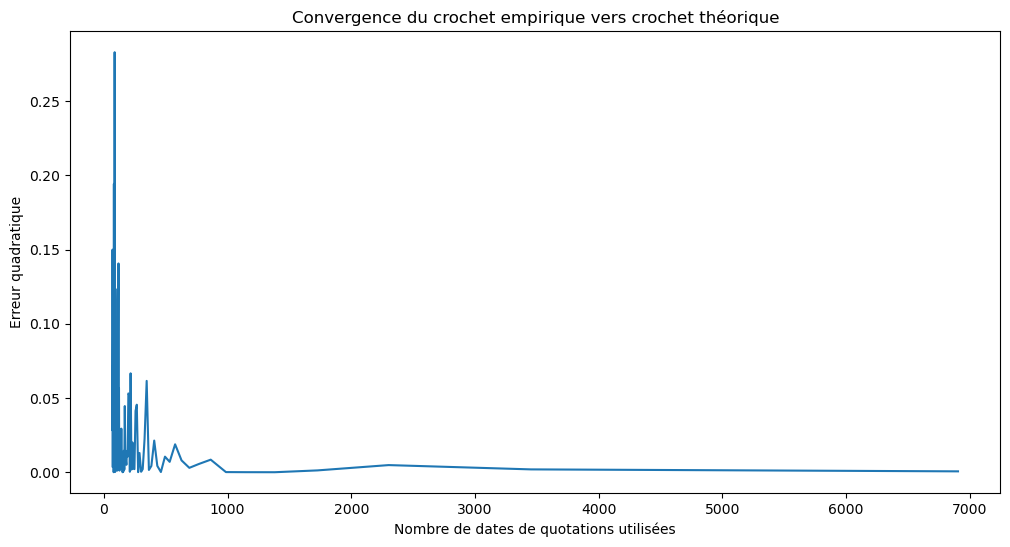

In [116]:
fig,ax=plt.subplots(figsize=(12,6))

ax.plot(Quotation_number,convergence_error)
ax.set_xlabel('Nombre de dates de quotations utilisées')
ax.set_ylabel('Erreur quadratique')
ax.set_title('Convergence du crochet empirique vers crochet théorique')

plt.show()

Cas Ti!=Tj

In [125]:
Ti='2020-10-15 20:00:00'
Tj='2020-11-30 07:00:00'
t0=base_date
maturities=[Ti,Tj]
simulation_results={}

In [126]:
t0, t = Get_brackets_borns_2(df, t0,Ti, Tj)
theoretical_bracket = quadratic_covariation(t0, t, Ti, Tj, sigmas[0], sigmas[1], vecteur_ai[0], rho_matrix[0,1])

In [128]:
convergence_error=[]
Quotation_number=[]
for steps_precision in range(100,0,-1):
    
    num_hours = int((pd.Timestamp(Ti) - pd.Timestamp(t0)).total_seconds() / 3600) - 1
    num_steps = int(num_hours/steps_precision)

    Quotation_number.append(num_steps)
    
    df_test=test_convergence(maturities,steps_precision,t0,converted_df_weekday_hour, vecteur_ai, rho_matrix, sigmas)
    empirical_bracket=calculate_sum(np.log(df_test), Ti,Tj)

    convergence_error.append((empirical_bracket-theoretical_bracket)**2)

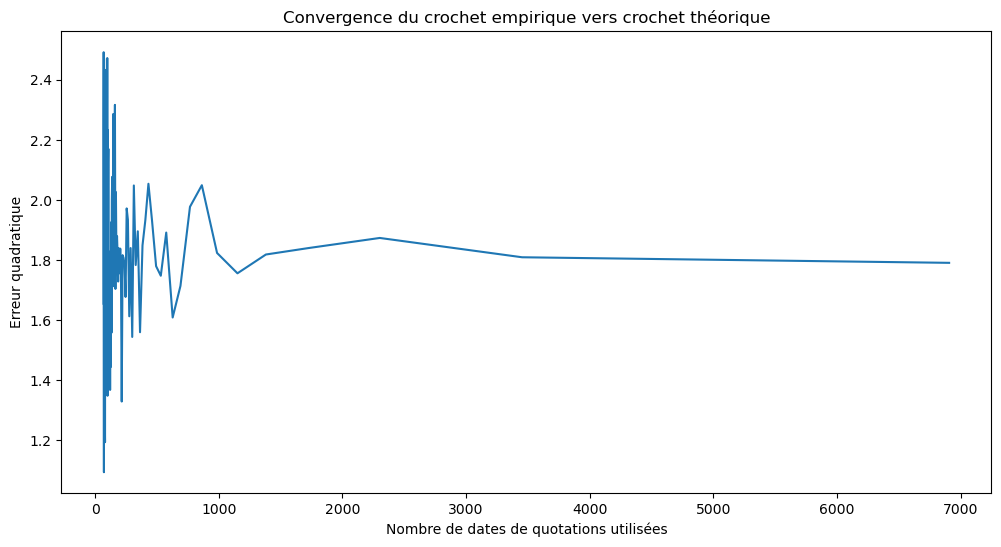

In [129]:
fig,ax=plt.subplots(figsize=(12,6))

ax.plot(Quotation_number,convergence_error)
ax.set_xlabel('Nombre de dates de quotations utilisées')
ax.set_ylabel('Erreur quadratique')
ax.set_title('Convergence du crochet empirique vers crochet théorique')

plt.show()

Il semble que l'estimateur converge avec la même vitesse mais qu'il est largement biaisé !